# Specify observables in the Pauli basis

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=1.3.2
qiskit-ibm-runtime~=0.34.0
qiskit-aer~=0.15.1
qiskit-serverless~=0.18.1
qiskit-ibm-catalog~=0.2
qiskit-addon-sqd~=0.8.1
qiskit-addon-utils~=0.1.0
qiskit-addon-mpf~=0.2.0
qiskit-addon-aqc-tensor~=0.1.2
qiskit-addon-obp~=0.1.0
scipy~=1.15.1
pyscf~=2.8.0; sys.platform != 'win32'
```
</details>

In quantum mechanics, observables correspond to physical properties that can be measured.
When considering a system of spins, for example, you could be interested in measuring the system's energy or obtaining information about the alignment of the spins, such as the magnetization or the correlations between spins.

To measure an $n$-qubit observable $O$ on a quantum computer, you must represent it as a sum of tensor products of Pauli operators, that is

$$
O = \sum_{k=1}^K \alpha_k P_k,~~ P_k \in \{I, X, Y, Z\}^{\otimes n},~~ \alpha_k \in \mathbb{R},
$$

where

$$
I = \begin{pmatrix}
1 & 0 \\ 0 & 1
\end{pmatrix}
~~
X = \begin{pmatrix}
0 & 1 \\ 1 & 0
\end{pmatrix}
~~
Y = \begin{pmatrix}
0 & -i \\ i & 0
\end{pmatrix}
~~
Z = \begin{pmatrix}
1 & 0 \\ 0 & -1
\end{pmatrix}
$$

and you use the fact that an observable is Hermitian, as in, $O^\dagger = O$. If $O$ is not Hermitian it can still be decomposed as a sum of Paulis, but the coefficient $\alpha_k$ becomes complex.

In many cases, the observable is naturally specified in this representation after mapping the system of interest to qubits.
For example, a spin-1/2 system can be mapped to an Ising Hamiltonian

$$
H = \sum_{\langle i, j\rangle} Z_i Z_j - \sum_{i=1}^n X_i,
$$

where the indices $\langle i, j\rangle$ run over interacting spins and the spins are subject to a transversal field in $X$.
The subscript index indicates which qubit the Pauli operator acts on, i.e. $X_i$ applies an $X$ operator on qubit $i$ and leaves the rest unchanged.

In the Qiskit SDK, this Hamiltonian could be constructed with the following code.

In [1]:
from qiskit.quantum_info import SparsePauliOp

# define the number of qubits
n = 12

# define the single Pauli terms as ("Paulis", [indices], coefficient)
interactions = [
    ("ZZ", [i, i + 1], 1) for i in range(n - 1)
]  # we assume spins on a 1D line
field = [("X", [i], -1) for i in range(n)]

# build the operator
hamiltonian = SparsePauliOp.from_sparse_list(
    interactions + field, num_qubits=n
)
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIZZ', 'IIIIIIIIIZZI', 'IIIIIIIIZZII', 'IIIIIIIZZIII', 'IIIIIIZZIIII', 'IIIIIZZIIIII', 'IIIIZZIIIIII', 'IIIZZIIIIIII', 'IIZZIIIIIIII', 'IZZIIIIIIIII', 'ZZIIIIIIIIII', 'IIIIIIIIIIIX', 'IIIIIIIIIIXI', 'IIIIIIIIIXII', 'IIIIIIIIXIII', 'IIIIIIIXIIII', 'IIIIIIXIIIII', 'IIIIIXIIIIII', 'IIIIXIIIIIII', 'IIIXIIIIIIII', 'IIXIIIIIIIII', 'IXIIIIIIIIII', 'XIIIIIIIIIII'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,
  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,
 -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])


If we would like to measure the energy the observable is the Hamiltonian itself. Alternatively, we could be
interested in measuring system properties like the average magnetization by counting the number of spins
aligned in the $Z$-direction with the observable

$$
O = \frac{1}{n} \sum_{i=1} Z_i
$$

For observables that are not given in terms of Pauli operators but in a matrix form, we first have to reformulate them
in the Pauli basis in order to evaluate them on a quantum computer.
We are always able to find such a representation as the Pauli matrices form a basis for the Hermitian $2^n \times 2^n$ matrices.
We expand the observable $O$ as

$$
O = \sum_{P \in \{I, X, Y, Z\}^{\otimes n}} \mathrm{Tr}(O P) P,
$$

where the sum runs over all possible $n$-qubit Pauli terms and $\mathrm{Tr}(\cdot)$ is the trace of a matrix, which acts as inner product.
You can implement this decomposition  from a matrix to Pauli terms using the `SparsePauliOp.from_operator` method, like so:

In [2]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

matrix = np.array(
    [[-1, 0, 0.5, -1], [0, 1, 1, 0.5], [0.5, 1, -1, 0], [-1, 0.5, 0, 1]]
)

observable = SparsePauliOp.from_operator(matrix)
print(observable)

SparsePauliOp(['IZ', 'XI', 'YY'],
              coeffs=[-1. +0.j,  0.5+0.j,  1. -0.j])


This means the matrix can be written as Pauli terms as $O = -Z_1 + 0.5 X_2 + Y_2 Y_1$.

<Admonition type="note">
  Remember the tensor product order maps to qubits as $q_n \otimes q_{n-1} \otimes \cdots \otimes q_1$.
</Admonition>

<Admonition type="note">
  If the observable is Hermitian (meaning $O^\dagger = O$), the Pauli coefficients are real numbers.
  We can, however, also decompose any other complex matrix in terms of Paulis, if we allow for complex-valued coefficients.
</Admonition>


## Measure in Pauli bases

A measurement projects the qubit state to the computational basis $\{|0\rangle, |1\rangle\}$. This implies that you can only measure observables that are diagonal in this basis, such as Paulis consisting only of $I$ and $Z$ terms.
Measuring arbitrary Pauli terms therefore requires a change of basis to diagonalize them. To do this, perform the following transformations,

$$
\begin{aligned}
    X &\rightarrow Z = H X H \\
    Y &\rightarrow Z = H S^\dagger Y S H,
\end{aligned}
$$

where $H$ is the Hadamard gate and $S = \sqrt{Z}$ is sometimes referred to as the phase gate.
If you are using an [Estimator](../api/qiskit/qiskit.primitives.Estimator) to compute expectation values, the basis transformations are automatically performed.

Below is an example demonstrating how to prepare a quantum circuit and manually measure the qubit 0 in the X basis,
qubit 1 in the Y basis and qubit 2 in the Z basis.
We apply the transformations shown in the previous equation and obtain the following circuit:

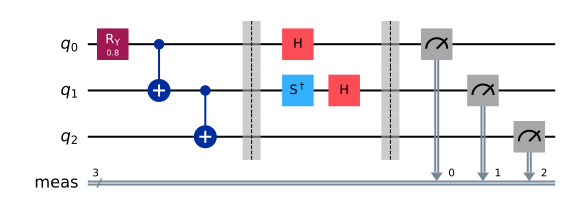

In [3]:
from qiskit.circuit import QuantumCircuit

# create a circuit, where we would like to measure
# q0 in the X basis, q1 in the Y basis and q2 in the Z basis
circuit = QuantumCircuit(3)
circuit.ry(0.8, 0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.barrier()

# diagonalize X with the Hadamard gate
circuit.h(0)

# diagonalize Y with Hadamard as S^\dagger
circuit.sdg(1)
circuit.h(1)

# the Z basis is the default, no action required here

# measure all qubits
circuit.measure_all()
circuit.draw("mpl")

## Next steps

<Admonition type="tip" title="Recommendations">
  -  See an example of circuit decomposition in the [Variational quantum eigensolver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver) tutorial.
  -  Read the [SparsePauliOp API](/api/qiskit/qiskit.quantum_info.SparsePauliOp#sparsepauliop) reference.
</Admonition>